# Import Library

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# cwd
print(f'Current working directory: {os.getcwd()}')
# change directory
os.chdir('../')
print(f'New working directory: {os.getcwd()}')

/var/folders/83/j83q5_mj11956_7k9tnld0ym0000gn/T/ipykernel_47125/3146130768.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Current working directory: /Users/gbemidebe/Documents/GitHub/CDImodeling/notebooks
New working directory: /Users/gbemidebe/Documents/GitHub/CDImodeling


In [2]:
from cdi.plotters import Plotters

plotter = Plotters()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Load Data

In [3]:
# SA --> surface area 
# DG --> defect ratio
# %N --> percent nitrogen
# %O --> percent oxygen
# %S --> percent sulphur
# CD --> current density
# CONC --> concentration of electrolyte
# CAP --> specific capacitance

In [4]:
import pandas as pd

desired_columns = ['SA', 'DG', '%N', '%O', '%S', 'CD', 'CONC', 'CAP']

data = pd.read_csv('data/specific_capacitance_data.csv')
data = data[desired_columns]
print(data.shape)
data.head()

(620, 8)


,SA,DG,%N,%O,%S,CD,CONC,CAP
0,1122.5,0.85,NaN,5.7,NaN,0.5,6.0,240.63
1,1122.5,0.85,NaN,5.7,NaN,1.0,6.0,228.13
2,1122.5,0.85,NaN,5.7,NaN,2.0,6.0,225.00
3,1122.5,0.85,NaN,5.7,NaN,5.0,6.0,215.63
4,1122.5,0.85,NaN,5.7,NaN,10.0,6.0,206.25


In [5]:
data.isna().sum()

SA        0
DG       79
%N      218
%O       78
%S      384
CD        0
CONC      0
CAP       0
dtype: int64

In [6]:
for col in data.columns:
    print(f'% of missing values in {col}: {data[col].isna().sum()/len(data)*100:.2f}%')

% of missing values in SA: 0.00%
% of missing values in DG: 12.74%
% of missing values in %N: 35.16%
% of missing values in %O: 12.58%
% of missing values in %S: 61.94%
% of missing values in CD: 0.00%
% of missing values in CONC: 0.00%
% of missing values in CAP: 0.00%


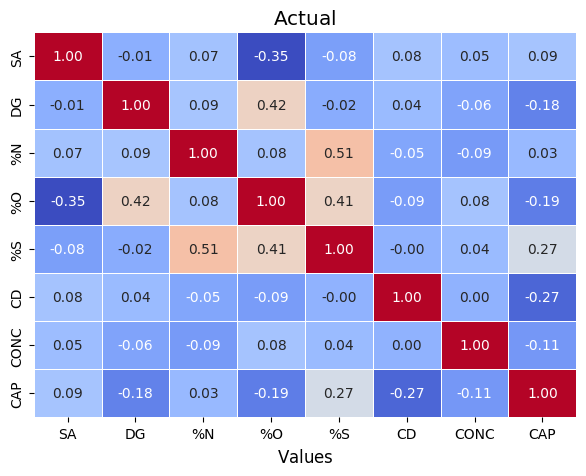

In [7]:
plotter.plot_heat_map(data=data, label = r'$ \rm Actual$', property = 'original',
                    fig_size = (7, 5), save_fig = False)

In [8]:
# drop missing values
clean_data = data.dropna()
print(clean_data.shape)
clean_data.head()

(159, 8)


,SA,DG,%N,%O,%S,CD,CONC,CAP
152,308.8,1.01,1.46,11.94,1.14,0.5,6.0,378.0
153,308.8,1.01,1.46,11.94,1.14,1.0,6.0,352.0
154,308.8,1.01,1.46,11.94,1.14,2.0,6.0,325.0
155,308.8,1.01,1.46,11.94,1.14,5.0,6.0,308.0
156,308.8,1.01,1.46,11.94,1.14,10.0,6.0,292.0


# Imputation

In [9]:
import pandas as pd
import numpy as np
from loguru import logger
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

from cdi.dataPreprocessing import Imputation

In [10]:
# create artificial missing values
def introduce_missing_values(dataframe, missing_fraction):
    mask = np.random.rand(*dataframe.shape) < missing_fraction
    dataframe[mask] = np.nan
    return dataframe

# Function to introduce artificial missing values in specific columns
def introduce_missing_values_in_columns(dataframe, columns, missing_fraction):
    for col in columns:
        mask = np.random.rand(dataframe[col].shape[0]) < missing_fraction
        dataframe.loc[mask, col] = np.nan
    return dataframe

In [11]:
idx = 'DG' #np.random.choice(clean_data.columns) #'SA' 

In [12]:
# set random state to reproduce the same results
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

## Case 1: 20%

In [13]:
missing_fraction = 0.20 # 0.20, 0.50, 0.70
clean_data_with_NaN = introduce_missing_values_in_columns(clean_data.copy(), [idx], missing_fraction)
clean_data_with_NaN.head()

,SA,DG,%N,%O,%S,CD,CONC,CAP
152,308.8,1.01,1.46,11.94,1.14,0.5,6.0,378.0
153,308.8,1.01,1.46,11.94,1.14,1.0,6.0,352.0
154,308.8,NaN,1.46,11.94,1.14,2.0,6.0,325.0
155,308.8,1.01,1.46,11.94,1.14,5.0,6.0,308.0
156,308.8,NaN,1.46,11.94,1.14,10.0,6.0,292.0


In [14]:
for col in clean_data_with_NaN.columns:
    print(f'% of missing values in {col}: {clean_data_with_NaN[col].isna().sum()/len(clean_data_with_NaN)*100:.2f}%')

% of missing values in SA: 0.00%
% of missing values in DG: 22.01%
% of missing values in %N: 0.00%
% of missing values in %O: 0.00%
% of missing values in %S: 0.00%
% of missing values in CD: 0.00%
% of missing values in CONC: 0.00%
% of missing values in CAP: 0.00%


#### KNN

In [15]:
method = 'KNN'
model = KNNImputer(n_neighbors=5, weights="uniform")


IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 11:50:16.095 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:         SA    DG    %N     %O    %S    CD  CONC    CAP
152  308.8  1.01  1.46  11.94  1.14   0.5   6.0  378.0
153  308.8  1.01  1.46  11.94  1.14   1.0   6.0  352.0
154  308.8   NaN  1.46  11.94  1.14   2.0   6.0  325.0
155  308.8  1.01  1.46  11.94  1.14   5.0   6.0  308.0
156  308.8   NaN  1.46  11.94  1.14  10.0   6.0  292.0
2024-02-15 11:50:16.096 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: KNN

2024-02-15 11:50:16.096 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 159
2024-02-15 11:50:16.097 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "SA": 0
2024-02-15 11:50:16.097 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "DG": 35
2024-02-15 11:50:16.097 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "%N": 0
2024-02-15 11:50:16.098 | WARNING  | cdi.dataPreprocessing:impute:106 -

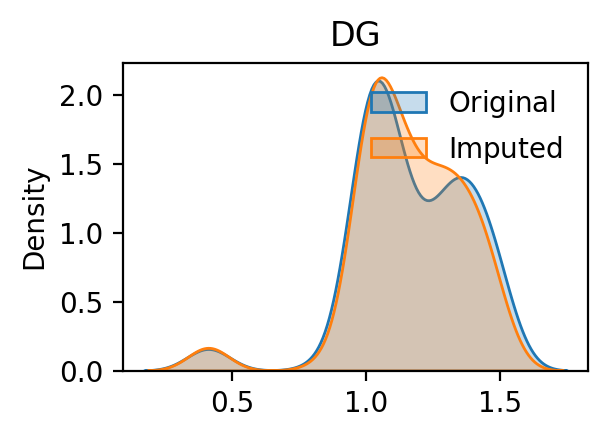

In [16]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

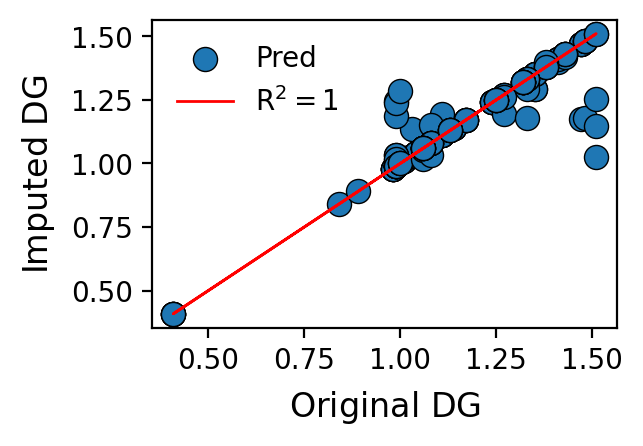

In [17]:
# crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [18]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

RMSE: 0.08
MAE: 0.02
R2: 0.88


#### Extra Tree Regressor

In [20]:
method = 'ExtraTreesRegressor'
model = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=20),
                                 random_state=0,
                                 max_iter=500)

IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 11:50:16.539 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:         SA    DG    %N     %O    %S    CD  CONC    CAP
152  308.8  1.01  1.46  11.94  1.14   0.5   6.0  378.0
153  308.8  1.01  1.46  11.94  1.14   1.0   6.0  352.0
154  308.8   NaN  1.46  11.94  1.14   2.0   6.0  325.0
155  308.8  1.01  1.46  11.94  1.14   5.0   6.0  308.0
156  308.8   NaN  1.46  11.94  1.14  10.0   6.0  292.0
2024-02-15 11:50:16.541 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: ExtraTreesRegressor

2024-02-15 11:50:16.541 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 159
2024-02-15 11:50:16.542 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "SA": 0
2024-02-15 11:50:16.543 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "DG": 35
2024-02-15 11:50:16.544 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "%N": 0
2024-02-15 11:50:16.544 | WARNING  | cdi.dataPreprocess

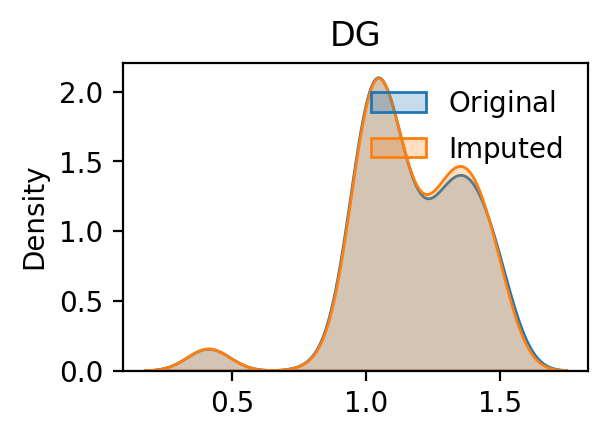

In [21]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

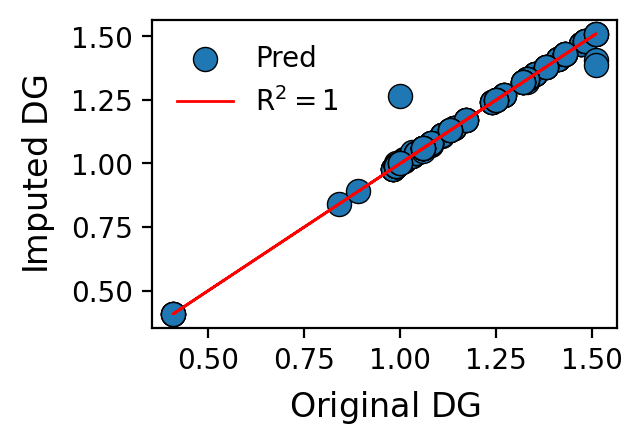

In [22]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [23]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX DG
RMSE: 0.02
MAE: 0.00
R2: 0.99


## Case 2: 50%

In [24]:
missing_fraction = 0.50 # 0.20, 0.50, 0.70
clean_data_with_NaN = introduce_missing_values_in_columns(clean_data.copy(), [idx], missing_fraction)
clean_data_with_NaN.head()

,SA,DG,%N,%O,%S,CD,CONC,CAP
152,308.8,NaN,1.46,11.94,1.14,0.5,6.0,378.0
153,308.8,NaN,1.46,11.94,1.14,1.0,6.0,352.0
154,308.8,NaN,1.46,11.94,1.14,2.0,6.0,325.0
155,308.8,NaN,1.46,11.94,1.14,5.0,6.0,308.0
156,308.8,NaN,1.46,11.94,1.14,10.0,6.0,292.0


In [25]:
for col in clean_data_with_NaN.columns:
    print(f'% of missing values in {col}: {clean_data_with_NaN[col].isna().sum()/len(clean_data_with_NaN)*100:.2f}%')

% of missing values in SA: 0.00%
% of missing values in DG: 57.86%
% of missing values in %N: 0.00%
% of missing values in %O: 0.00%
% of missing values in %S: 0.00%
% of missing values in CD: 0.00%
% of missing values in CONC: 0.00%
% of missing values in CAP: 0.00%


#### KNN

In [26]:
method = 'KNN'
model = KNNImputer(n_neighbors=5, weights="uniform")


IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 11:50:16.955 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:         SA  DG    %N     %O    %S    CD  CONC    CAP
152  308.8 NaN  1.46  11.94  1.14   0.5   6.0  378.0
153  308.8 NaN  1.46  11.94  1.14   1.0   6.0  352.0
154  308.8 NaN  1.46  11.94  1.14   2.0   6.0  325.0
155  308.8 NaN  1.46  11.94  1.14   5.0   6.0  308.0
156  308.8 NaN  1.46  11.94  1.14  10.0   6.0  292.0
2024-02-15 11:50:16.957 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: KNN

2024-02-15 11:50:16.957 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 159
2024-02-15 11:50:16.958 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "SA": 0
2024-02-15 11:50:16.958 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "DG": 92
2024-02-15 11:50:16.958 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "%N": 0
2024-02-15 11:50:16.959 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of m

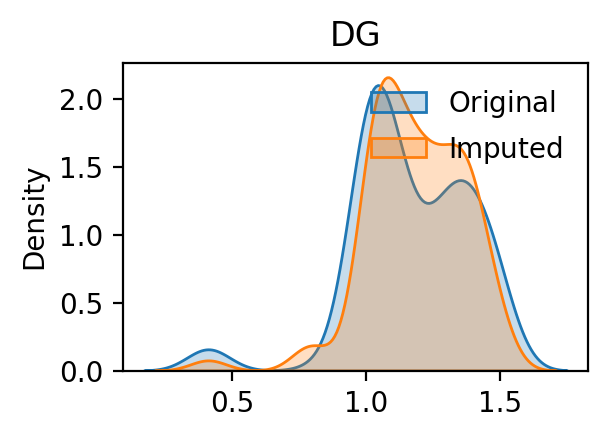

In [27]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

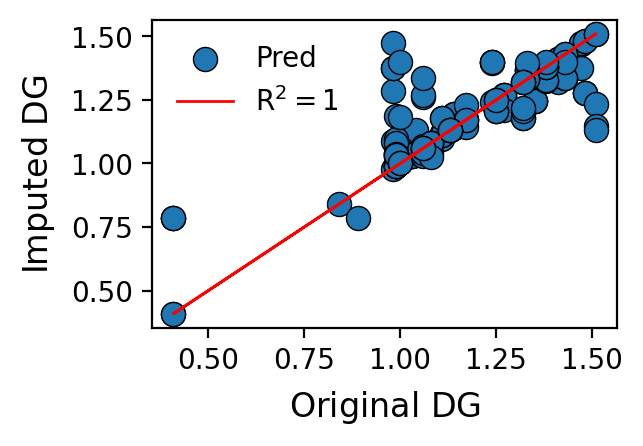

In [28]:
# crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [29]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX DG
RMSE: 0.12
MAE: 0.06
R2: 0.70


#### Extra Tree Regressor

In [30]:
method = 'ExtraTreesRegressor'
model = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=20),
                                 random_state=0,
                                 max_iter=500)

IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 11:50:17.324 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:         SA  DG    %N     %O    %S    CD  CONC    CAP
152  308.8 NaN  1.46  11.94  1.14   0.5   6.0  378.0
153  308.8 NaN  1.46  11.94  1.14   1.0   6.0  352.0
154  308.8 NaN  1.46  11.94  1.14   2.0   6.0  325.0
155  308.8 NaN  1.46  11.94  1.14   5.0   6.0  308.0
156  308.8 NaN  1.46  11.94  1.14  10.0   6.0  292.0
2024-02-15 11:50:17.325 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: ExtraTreesRegressor

2024-02-15 11:50:17.326 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 159
2024-02-15 11:50:17.326 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "SA": 0
2024-02-15 11:50:17.326 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "DG": 92
2024-02-15 11:50:17.327 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "%N": 0
2024-02-15 11:50:17.327 | WARNING  | cdi.dataPreprocessing:impute:1

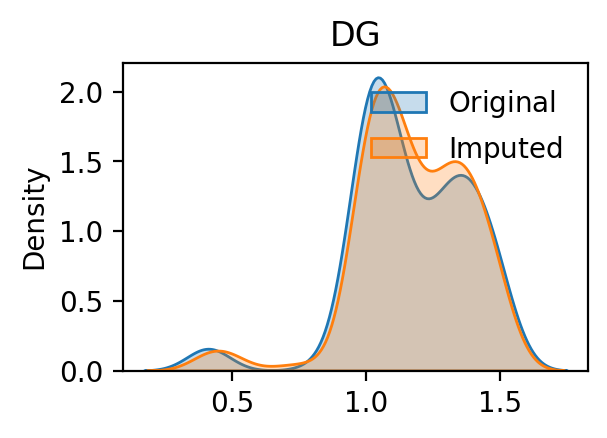

In [31]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

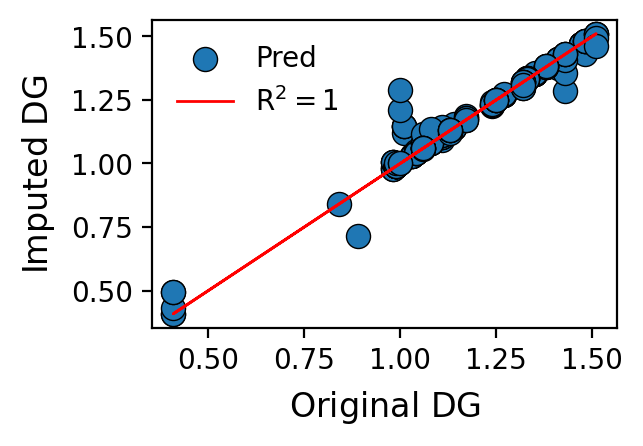

In [32]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [33]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX DG
RMSE: 0.04
MAE: 0.02
R2: 0.96


## Case 3: 70%

In [34]:
missing_fraction = 0.70 # 0.20, 0.50, 0.70
clean_data_with_NaN = introduce_missing_values_in_columns(clean_data.copy(), [idx], missing_fraction)
clean_data_with_NaN.head()

,SA,DG,%N,%O,%S,CD,CONC,CAP
152,308.8,NaN,1.46,11.94,1.14,0.5,6.0,378.0
153,308.8,NaN,1.46,11.94,1.14,1.0,6.0,352.0
154,308.8,NaN,1.46,11.94,1.14,2.0,6.0,325.0
155,308.8,NaN,1.46,11.94,1.14,5.0,6.0,308.0
156,308.8,NaN,1.46,11.94,1.14,10.0,6.0,292.0


In [35]:
for col in clean_data_with_NaN.columns:
    print(f'% of missing values in {col}: {clean_data_with_NaN[col].isna().sum()/len(clean_data_with_NaN)*100:.2f}%')

% of missing values in SA: 0.00%
% of missing values in DG: 71.70%
% of missing values in %N: 0.00%
% of missing values in %O: 0.00%
% of missing values in %S: 0.00%
% of missing values in CD: 0.00%
% of missing values in CONC: 0.00%
% of missing values in CAP: 0.00%


#### KNN

In [36]:
method = 'KNN'
model = KNNImputer(n_neighbors=5, weights="uniform")


IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 11:50:17.906 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:         SA  DG    %N     %O    %S    CD  CONC    CAP
152  308.8 NaN  1.46  11.94  1.14   0.5   6.0  378.0
153  308.8 NaN  1.46  11.94  1.14   1.0   6.0  352.0
154  308.8 NaN  1.46  11.94  1.14   2.0   6.0  325.0
155  308.8 NaN  1.46  11.94  1.14   5.0   6.0  308.0
156  308.8 NaN  1.46  11.94  1.14  10.0   6.0  292.0
2024-02-15 11:50:17.907 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: KNN

2024-02-15 11:50:17.909 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 159
2024-02-15 11:50:17.910 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "SA": 0
2024-02-15 11:50:17.910 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "DG": 114
2024-02-15 11:50:17.911 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "%N": 0
2024-02-15 11:50:17.912 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of 

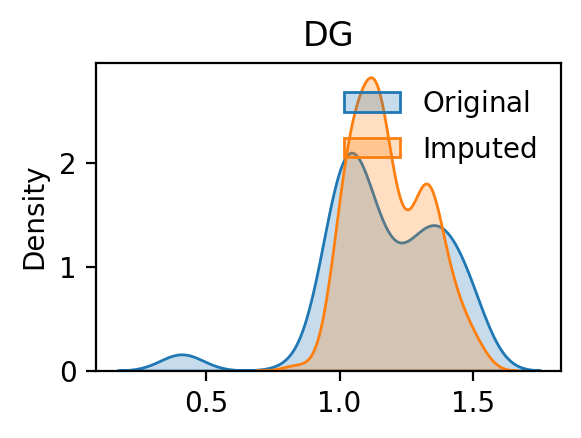

In [37]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

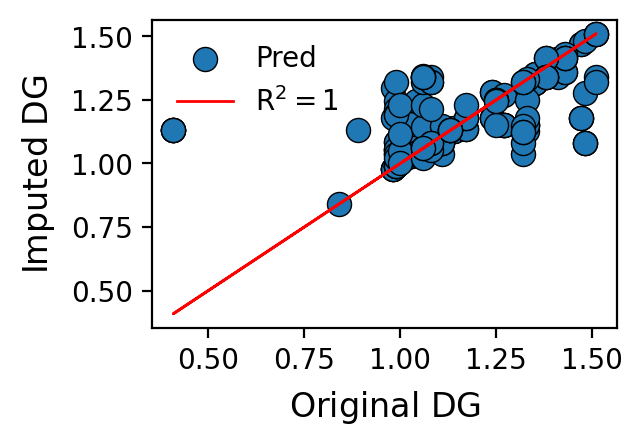

In [38]:
# crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [39]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

RMSE: 0.18
MAE: 0.10
R2: 0.30


#### Extra Tree Regressor

In [40]:
method = 'ExtraTreesRegressor'
model = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=20),
                                 random_state=0,
                                 max_iter=500)

IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 11:50:18.468 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:         SA  DG    %N     %O    %S    CD  CONC    CAP
152  308.8 NaN  1.46  11.94  1.14   0.5   6.0  378.0
153  308.8 NaN  1.46  11.94  1.14   1.0   6.0  352.0
154  308.8 NaN  1.46  11.94  1.14   2.0   6.0  325.0
155  308.8 NaN  1.46  11.94  1.14   5.0   6.0  308.0
156  308.8 NaN  1.46  11.94  1.14  10.0   6.0  292.0
2024-02-15 11:50:18.469 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: ExtraTreesRegressor

2024-02-15 11:50:18.470 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 159
2024-02-15 11:50:18.472 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "SA": 0
2024-02-15 11:50:18.473 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "DG": 114
2024-02-15 11:50:18.474 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "%N": 0
2024-02-15 11:50:18.474 | WARNING  | cdi.dataPreprocessing:impute:

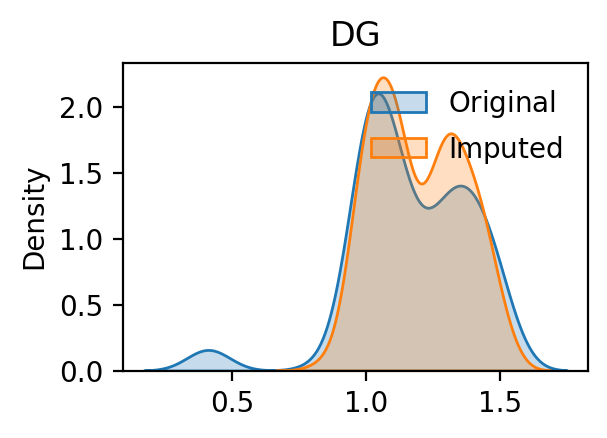

In [41]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

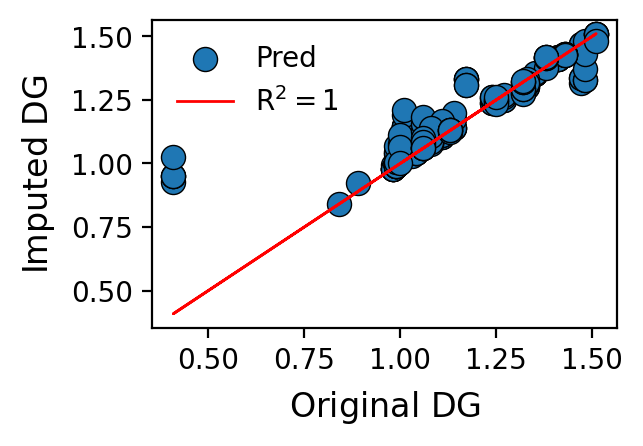

In [42]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [43]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX DG
RMSE: 0.11
MAE: 0.05
R2: 0.74
